In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import dask.dataframe as dd
import dask
from collections import defaultdict
from pathlib import Path
import torch
from tqdm.notebook import tqdm


# Import our utility functions
sys.path.append('..')
from notebooks.file_structure_utils import (
    get_image_path,
    get_available_channels,
)

data_dir = '/orcd/data/omarabu/001/njwfish/DistributionEmbeddings/data/ops'

In [2]:
pdf = pd.read_parquet(
    data_dir+'/interphase-reclassified_cp_phenotype_normalized.parquet', 
    columns=['gene_symbol_0', 'plate', 'tile', 'well', 'bounds_0', 'bounds_1', 'bounds_2', 'bounds_3']
)

In [3]:
import torch
import torch.nn.functional as F

def center_pad_tensor(img_tensor: torch.Tensor, target_size: tuple, pad_value: float = 0.0):
    """
    Center pad a 3D tensor (C x H x W) to the given target size.
    
    Args:
        img_tensor: torch.Tensor of shape (C, H, W)
        target_size: Tuple (target_height, target_width)
        pad_value: Scalar to use for padding.
        
    Returns:
        torch.Tensor of shape (C, target_height, target_width)
    """
    _, h, w = img_tensor.shape
    target_h, target_w = target_size

    pad_h = max(target_h - h, 0)
    pad_w = max(target_w - w, 0)

    # Padding format for 3D tensor is (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom)
    padding = [
        pad_w // 2, pad_w - pad_w // 2,
        pad_h // 2, pad_h - pad_h // 2
    ]

    return F.pad(img_tensor, padding, value=pad_value)


def build_crop_dict(plate, well, tile, image_metadata, max_height=104, max_width=104, n_imgs=10):
    available_channels = get_available_channels(plate, well, tile, base_dir=data_dir)
    
    if 'DAPI-GFP' in available_channels:
        image_path = get_image_path(plate, well, tile, 'DAPI-GFP', data_dir, 'screenA')
        
        # Check if file exists
        if not image_path or not os.path.exists(image_path):
            print(f"Warning: File not found")
            return
            
        # Load full image
        full_image = io.imread(image_path)
        single_cell_images = []
        if len(full_image.shape) == 4 and full_image.shape[1] == 2:
            # only use the first channel of the image since they are basically the same (diff resolutions maybe)
            dapi_image = full_image[0, 0]
            gfp_image = full_image[0, 1]

            for row in image_metadata.itertuples():
                bounds = [row.bounds_0, row.bounds_1, row.bounds_2, row.bounds_3]
                # if the cell is too big, crop it to the max size
                if (bounds[2] - bounds[0]) > max_height:
                    bounds[0] = bounds[0] + (bounds[2] - bounds[0] - max_height) // 2
                    bounds[2] = bounds[0] + max_height
                if (bounds[3] - bounds[1]) > max_width:
                    bounds[1] = bounds[1] + (bounds[3] - bounds[1] - max_width) // 2
                    bounds[3] = bounds[1] + max_width
                dapi_cell_image = dapi_image[bounds[0]:bounds[2], bounds[1]:bounds[3]]
                gfp_cell_image = gfp_image[bounds[0]:bounds[2], bounds[1]:bounds[3]]
                stacked_image = torch.stack([
                    torch.tensor(dapi_cell_image), 
                    torch.tensor(gfp_cell_image)
                ])
                padded_stacked_image = center_pad_tensor(stacked_image, (max_height, max_width))
                single_cell_images.append(padded_stacked_image)
        
        single_cell_images = torch.stack(single_cell_images)

    return single_cell_images  # {perturbation: [list of (2, h, w)]}

In [ ]:
import pickle
gdfs = pdf.groupby(['plate', 'well', 'tile'])
for i, ((plate, well, tile), gdf) in enumerate(gdfs):
    print(f"{i}/{len(gdfs)}: {plate}, {well}, {tile}")
    if os.path.exists(f"{data_dir}/processed/{plate}/{well}/{tile}/gdf.parquet"):
        continue
    gdf = gdf.reset_index(drop=True)
    gdf['center_x'] = (gdf['bounds_0'] + gdf['bounds_2']) / 2
    gdf['center_y'] = (gdf['bounds_1'] + gdf['bounds_3']) / 2
    pos = np.vstack([gdf['center_x'].values, gdf['center_y'].values]).T
    pert_indices = gdf.groupby('gene_symbol_0').groups
    # compute pairwise distances
    dist_matrix = np.linalg.norm(pos[:, None, :] / 2960 - pos[None, :, :] / 2960, axis=-1)
    # set the diagonal to infinity
    dist_matrix[np.arange(len(dist_matrix)), np.arange(len(dist_matrix))] = np.inf
    single_cell_images = build_crop_dict(plate, well, tile, gdf, max_height=104, max_width=104).numpy()
    os.makedirs(f"{data_dir}/processed/{plate}/{well}/{tile}", exist_ok=True)
    np.save(f"{data_dir}/processed/{plate}/{well}/{tile}/dist_matrix", dist_matrix)
    np.save(f"{data_dir}/processed/{plate}/{well}/{tile}/single_cell_images", single_cell_images)
    pickle.dump(pert_indices, open(f"{data_dir}/processed/{plate}/{well}/{tile}/pert_indices.pkl", "wb"))
    gdf.to_parquet(f"{data_dir}/processed/{plate}/{well}/{tile}/gdf.parquet")


0/58822: 20200202_6W-LaC024A, A1, 0
1/58822: 20200202_6W-LaC024A, A1, 1
2/58822: 20200202_6W-LaC024A, A1, 2
3/58822: 20200202_6W-LaC024A, A1, 3
4/58822: 20200202_6W-LaC024A, A1, 4
5/58822: 20200202_6W-LaC024A, A1, 5
6/58822: 20200202_6W-LaC024A, A1, 6
7/58822: 20200202_6W-LaC024A, A1, 7
8/58822: 20200202_6W-LaC024A, A1, 8
9/58822: 20200202_6W-LaC024A, A1, 9
10/58822: 20200202_6W-LaC024A, A1, 10
11/58822: 20200202_6W-LaC024A, A1, 11
12/58822: 20200202_6W-LaC024A, A1, 12
13/58822: 20200202_6W-LaC024A, A1, 13
14/58822: 20200202_6W-LaC024A, A1, 14
15/58822: 20200202_6W-LaC024A, A1, 15
16/58822: 20200202_6W-LaC024A, A1, 16
17/58822: 20200202_6W-LaC024A, A1, 17
18/58822: 20200202_6W-LaC024A, A1, 18
19/58822: 20200202_6W-LaC024A, A1, 19
20/58822: 20200202_6W-LaC024A, A1, 20
21/58822: 20200202_6W-LaC024A, A1, 21
22/58822: 20200202_6W-LaC024A, A1, 22
23/58822: 20200202_6W-LaC024A, A1, 23
24/58822: 20200202_6W-LaC024A, A1, 24
25/58822: 20200202_6W-LaC024A, A1, 25
26/58822: 20200202_6W-LaC024A, A

In [44]:
from collections import defaultdict
import os
import numpy as np
from glob import glob
import pickle
import torch
from torch.utils.data import Dataset

class OPSDataset(Dataset):
    def __init__(
            self, 
            set_size: int = 100,
            prob_spatial: float = 0.5,
            spatial_kernel_width: float = 10,
            replace: bool = False,
            data_dir: str = "/orcd/data/omarabu/001/njwfish/DistributionEmbeddings/notebooks"
        ):
        
        self.set_size = set_size
        self.prob_spatial = prob_spatial
        self.replace = replace
        self.data_dir = data_dir
        self.spatial_kernel_width = spatial_kernel_width

        tiles = sorted(glob(f"{data_dir}/screenA/processed/*/*/*"))

        self.images = []
        self.pert_indices = defaultdict(list)
        self.dist_matrices = []
        self.tile_to_idx = []

        image_index = 0
        cumulative_index = 0
        for tile_path in tiles:
            if os.path.exists(f"{tile_path}/gdf.parquet"):
                self.images.append(np.load(f"{tile_path}/single_cell_images.pt", weights_only=False))
                
                pert_indices = pickle.load(open(f"{tile_path}/pert_indices.pkl", "rb"))
                for k in pert_indices:
                    pert_indices[k] += cumulative_index
                    self.pert_indices[k].extend(pert_indices[k])
                
                self.dist_matrices.append(np.load(f"{tile_path}/dist_matrix.pt", weights_only=False))
                self.tile_to_idx.append((cumulative_index, self.images[-1].shape[0]))
                image_index += 1
                cumulative_index += len(self.images[-1])

        self.images = np.concatenate(self.images)
        for k in self.pert_indices:
            self.pert_indices[k] = np.array(self.pert_indices[k])
    
    def __len__(self):
        return self.images.shape[0] // self.set_size
    

    def _sample_spatial(self):
        # sample a random tile
        tile_idx = np.random.randint(0, len(self.tile_to_idx))
        tile_start, tile_len = self.tile_to_idx[tile_idx]
        center_cell_idx = np.random.randint(0, tile_len)
        
        dist_matrix = self.dist_matrices[tile_idx][center_cell_idx]
        prob_dist = np.exp(-self.spatial_kernel_width * dist_matrix)
        prob_dist /= prob_dist.sum()
        cell_idx = np.random.choice(
            np.arange(len(prob_dist)), size=self.set_size, p=prob_dist, 
            replace=self.replace or self.set_size > tile_len
        )
        return cell_idx + tile_start
    
    def _sample_pert(self):
        # sample a random perturbation
        pert_to_sample = np.random.choice(list(self.pert_indices.keys()))
        pert_idx = np.random.choice(self.pert_indices[pert_to_sample], size=self.set_size, replace=self.replace or self.set_size > len(self.pert_indices[pert_to_sample]))
        return pert_idx, pert_to_sample
    
    def __getitem__(self, idx):
        sample_spatial = np.random.binomial(1, self.prob_spatial)
        if sample_spatial:
            idx = self._sample_spatial()
            # might be nice to save the pert so i can easily return that here 
            return {
                'samples': torch.tensor(self.images[idx]).float(),
                # 'pert': np.repeat(-1, self.set_size)
            }
        else:
            # sample a random image
            idx, pert_to_sample = self._sample_pert()
            return {
                'samples': torch.tensor(self.images[idx]).float(),
                # 'pert': np.repeat(pert_to_sample, self.set_size)
            }
        

ds = OPSDataset()

In [45]:
from torch.utils.data import DataLoader

dl = DataLoader(ds, batch_size=100, shuffle=True)

for batch in dl:
    print(batch)
    break

{'samples': tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0

In [42]:
batch['samples'].shape

torch.Size([69, 100, 2, 104, 104])

In [93]:
df = pdf

print('grouping by img, this takes ~1m')
grouped = defaultdict(list)
for row in df.itertuples():
    print(row)
    grouped[(row.plate, row.well, row.tile)].append([
        row.gene_symbol_0, 
        row.bounds_0, row.bounds_1, 
        row.bounds_2, row.bounds_3
    ])
    break


grouping by img, this takes ~1m
Pandas(Index='AAAACAAAAGCAGATGACCG', gene_symbol_0='CCNT1', plate='20200202_6W-LaC024A', tile=211, well='A1', bounds_0=1285, bounds_1=2704, bounds_2=1339, bounds_3=2758)


In [82]:
cd = build_crop_dict(pdf, max_height=60, max_width=60, n_imgs=10)

grouping by img, this takes ~1m


0it [00:00, ?it/s]

/tmp/ipykernel_4185045/2271490153.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dapi_cell_image),
/tmp/ipykernel_4185045/2271490153.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(gfp_cell_image)
/tmp/ipykernel_4185045/2271490153.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dapi_cell_image),
/tmp/ipykernel_4185045/2271490153.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

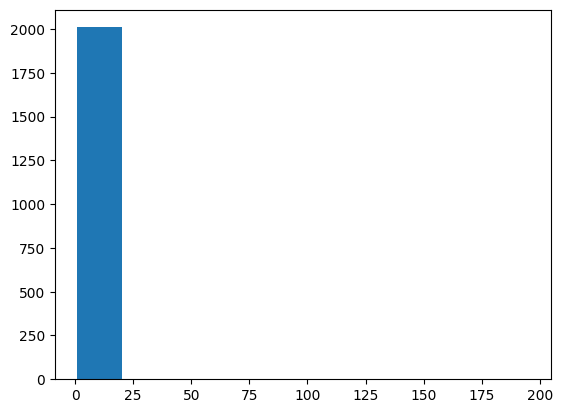

total cells:  7347
total perts:  2012
number of nontargeting:  195


In [83]:
counts = {k:len(v) for k,v in cd.items()}
plt.hist(list(counts.values()))
plt.show()

print('total cells: ', sum(list(counts.values())))
print('total perts: ', len(counts))
print('number of nontargeting: ', counts['nontargeting'])

DAPI:


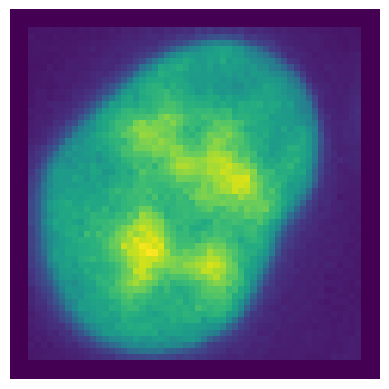

GFP:


(-0.5, 59.5, 59.5, -0.5)

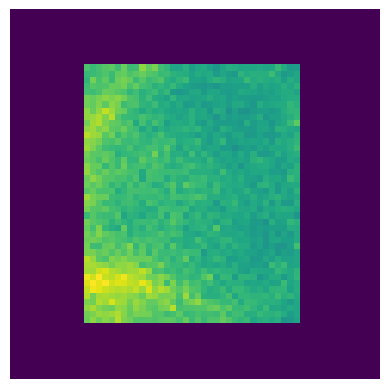

In [88]:
print('DAPI:')
plt.imshow(cd['CCNT1'][0][0, :, :])
plt.axis('off')
plt.show()
print('GFP:')
plt.imshow(cd['CCNT1'][5][1, :, :])
plt.axis('off')